In [22]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.svm import SVC

import matplotlib.pyplot as plt


In [252]:
train_data_set = np.load("fashion_train.npy")


# We have 10000 images in the training set
len(train_data_set)

# To find classification for each element, the last value in the set is:
# 0 for T-shirt/top
# 1 for Trousers
# 2 for Pullover
# 3 for Dress
# 4 for Shirt
len(train_data_set[0])

785

In [253]:
# We need to clean the array, as the last value is the classification. Let's first save these separately.

train_classes = []

for i in range(len(train_data_set)):
    train_classes.append(train_data_set[i][784])
      
train_classes = np.array(train_classes)

In [254]:
# Now we can delete the last element and have a cleaned training set that we can work with.

cleaned_train_set = np.empty((len(train_data_set), 784), dtype=np.uint8)

for i in range(len(train_data_set)):
    temp = np.delete(train_data_set[i], 784)
    cleaned_train_set[i] = temp

In [255]:
len(cleaned_train_set[0])

784

In [256]:
# Cleaning values close to 0 to reduce noise in the images.

for i in cleaned_train_set:
    for j in range(784):
        if i[j] < 14:
            i[j] = 0

In [264]:
# Standardize the data
scaler = StandardScaler()
standardized_train_data = scaler.fit_transform(cleaned_train_set)


In [265]:
# We reshape it so that the 1D array becomes a 2D 28x28 array.
cleaned_train_set_reshaped = cleaned_train_set.reshape(-1, 28, 28)

In [2]:
# Two simple functions for working with our data

def show_image(index_num):
    '''
    Simple function for showing the image and printing the category.
    
    index_num: The index you would like to show.
    '''
    img = cleaned_train_set_reshaped[index_num]
    #img2 = np.invert(img)
    plt.imshow(np.invert(img), cmap ='gray', vmin = 0, vmax = 255)
    plt.show()

    cloth_cat = train_classes[index_num]
    if cloth_cat == 0:
        print("0: This is a t-shirt/top")
    if cloth_cat == 1:
        print("1: This is a pair of trousers")
    if cloth_cat == 2:
        print("2: This is a pullover")
    if cloth_cat == 3:
        print("3: This is a dress")
    if cloth_cat == 4:
        print("4: This is a shirt")
        
def count_categories(categories):
    '''
    Another stupidly simple function for counting the categories.
    
    categories: The numpy array of all categories, corresponding to index number.
    '''  
    ze_val = 0
    on_val = 0
    tw_val = 0
    th_val = 0
    fo_val = 0
    for i in categories:
        if i == 0:
            ze_val += 1
        if i == 1:
            on_val += 1
        if i == 2:
            tw_val += 1
        if i == 3:
            th_val += 1
        if i == 4:
            fo_val += 1
    
    print(f'There are {ze_val} t-shirts/tops. There are {on_val} pairs of trousers. There are {tw_val} pullovers. There are {th_val} dresses. There are {fo_val} shirts.')
    

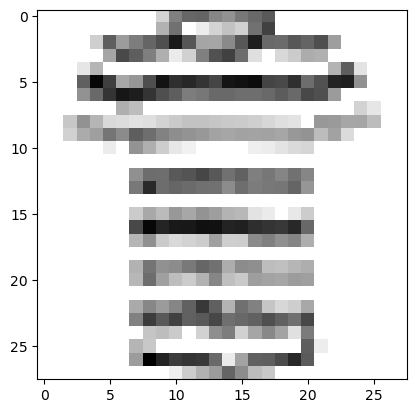

0: This is a t-shirt/top
There are 2033 t-shirts/tops. There are 1947 pairs of trousers. There are 2001 pullovers. There are 2005 dresses. There are 2014 shirts.


In [267]:
show_image(55)

count_categories(train_classes)

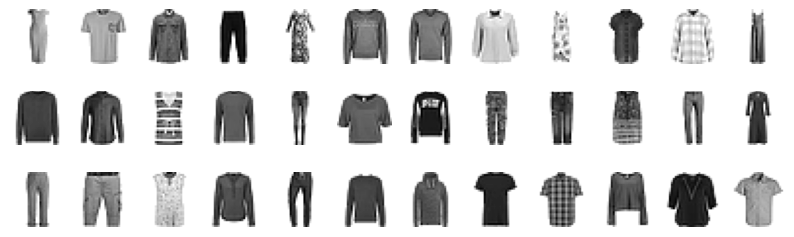

In [268]:
fig, axarr = plt.subplots( 3, 12, figsize=(10, 3))
ax = plt.Axes(fig, [0, 0, 1, 1.])
for y, a in enumerate(axarr[1]):
    axarr[0,y].set_axis_off()
    axarr[1,y].set_axis_off()
    axarr[2,y].set_axis_off()
    axarr[0,y].imshow((np.invert(cleaned_train_set_reshaped[random.randint(0,9999)])), cmap='gray')
    axarr[1,y].imshow((np.invert(cleaned_train_set_reshaped[random.randint(0,9999)])), cmap='gray')
    axarr[2,y].imshow((np.invert(cleaned_train_set_reshaped[random.randint(0,9999)])), cmap='gray')

In [269]:
cleaned_train_set_reshaped.shape

(10000, 28, 28)

Transformed data shape: (10000, 210)
Explained variance ratio: [0.22603368 0.13609817 0.06358945 0.05010653 0.03062702 0.02909299
 0.02197392 0.01885609 0.01473657 0.01421748 0.01296357 0.0123481
 0.01009283 0.00926477 0.00884594 0.00841715 0.00791795 0.00741845
 0.00719492 0.00682203 0.00638955 0.0062316  0.00593573 0.00557688
 0.005205   0.0050137  0.00493918 0.00478883 0.00455162 0.0044037
 0.00420612 0.00405006 0.00396849 0.00389328 0.00379286 0.00364704
 0.00359468 0.00354001 0.00334749 0.00325407 0.00318967 0.00314184
 0.00302833 0.00292203 0.00276837 0.00273281 0.00264286 0.00259014
 0.00245174 0.0024481  0.00234343 0.00230503 0.00221795 0.00216621
 0.00212285 0.00205767 0.002036   0.0019688  0.00193612 0.00186013
 0.00184001 0.00179804 0.00176936 0.00172659 0.00168418 0.00165854
 0.00163789 0.00159424 0.00158617 0.00152982 0.00149227 0.00148737
 0.00147779 0.00146116 0.00143459 0.00142943 0.00141072 0.00137027
 0.00134998 0.00133313 0.00130898 0.00128261 0.00126816 0.00126208
 

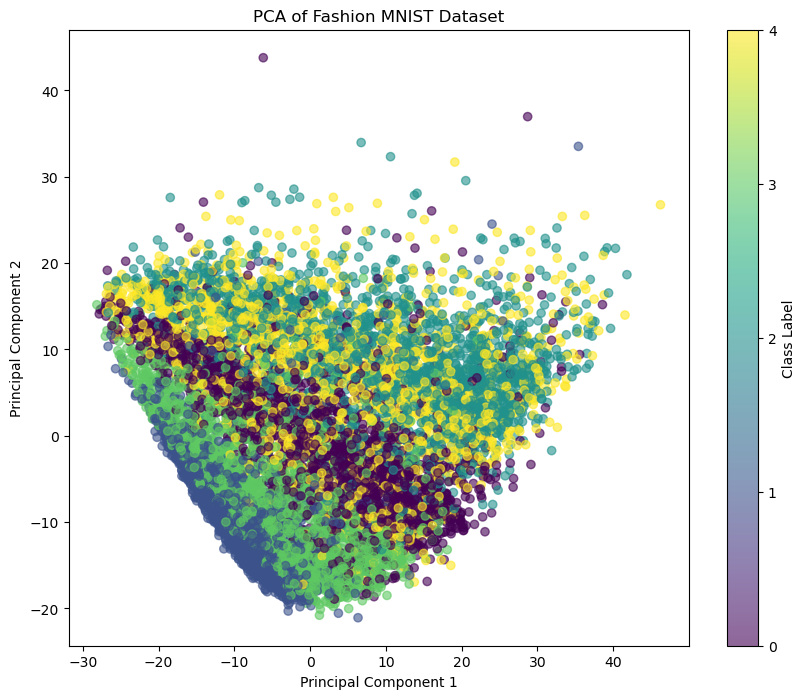

In [270]:

# Perform PCA
pca = PCA(n_components=210)  # You can adjust this number if needed
pca_train_result = pca.fit_transform(standardized_train_data)

# Print the shapes and explained variance ratio
print("Transformed data shape:", pca_train_result.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Visualize the first two principal components
pca_2d = pca_train_result[:, :2]  # Get the first two components

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=train_classes, cmap='viridis', alpha=0.6)

# Add colorbar
plt.colorbar(scatter, ticks=range(10), label='Class Label')

# Label axes and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Fashion MNIST Dataset')

# Show the plot
plt.show()


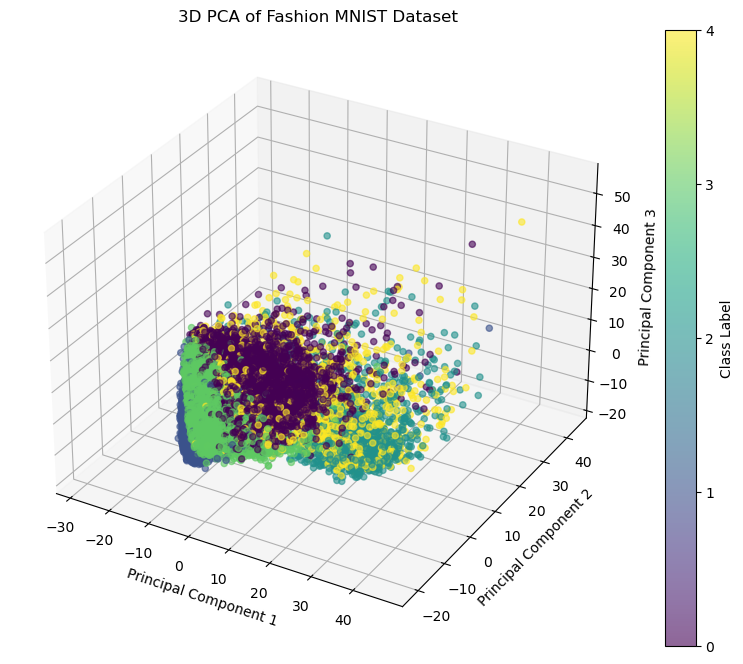

In [272]:
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Get the first three principal components
pca_3d = pca_train_result[:, :3]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points
scatter = ax.scatter(pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2], c=train_classes, cmap='viridis', alpha=0.6)

# Add a color bar
plt.colorbar(scatter, ticks=range(10), label='Class Label')

# Set labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Fashion MNIST Dataset')

# Show the plot
plt.show()

In [278]:
pca_3d.shape

(10000, 3)

In [289]:
type(pca_3d)

df_test = pd.DataFrame(pca_3d)

In [297]:
from scipy.stats import iqr


iqr_list = []
for i in range(len(pca_3d)):
    iqr_test = iqr(pca_3d[i])
    iqr_list.append(iqr_test)

## Removing Outliers using IQR and plotting with KMeans
Below we clean up the data using IQR.

In [322]:
def remove_outliers_iqr(data, classifiers):
    # Compute Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(pca_3d, 25, axis=0)
    Q3 = np.percentile(pca_3d, 75, axis=0)
    
    # Compute IQR
    IQR = Q3 - Q1
    
    # Define bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create a boolean mask for non-outliers
    mask = ~((data < lower_bound) | (data > upper_bound)).any(axis=1)
    
    # Filter data using the mask
    filtered_data = data[mask]
    classifiers_data = classifiers[mask]
    
    return filtered_data, mask, classifiers_data

# Example usage with PCA transformed data
# Assuming pca_train_result is your PCA data
cleaned_data_3d, outlier_mask, cleaned_classifiers_3d = remove_outliers_iqr(pca_3d, train_classes)

# Check shapes before and after
print("Original data shape:", pca_3d.shape)
print("Data shape after outlier removal:", cleaned_data_3d.shape)

Original data shape: (10000, 3)
Data shape after outlier removal: (9705, 3)


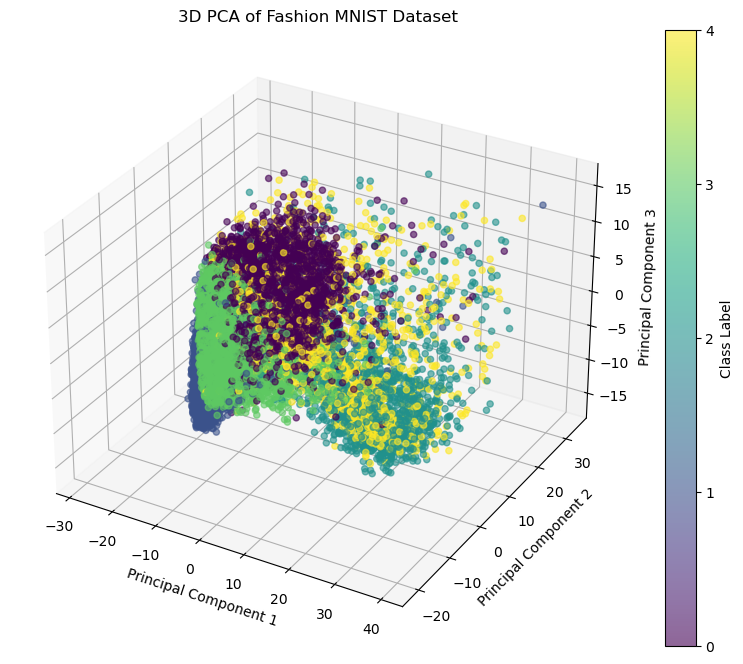

In [327]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points
scatter = ax.scatter(cleaned_data_3d[:, 0], cleaned_data_3d[:, 1], cleaned_data_3d[:, 2], c=cleaned_classifiers_3d, cmap='viridis', alpha=0.6)

# Add a color bar
plt.colorbar(scatter, ticks=range(10), label='Class Label')

# Set labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Fashion MNIST Dataset')

# Show the plot
plt.show()

In [340]:
# KMeans clustering of the dataset

from sklearn.cluster import KMeans

k_means_train_test = KMeans(n_clusters = 5,random_state=42, n_init='auto').fit(cleaned_data_3d)

k_labels = k_means_train_test.labels_
k_centers = k_means_train_test.cluster_centers_

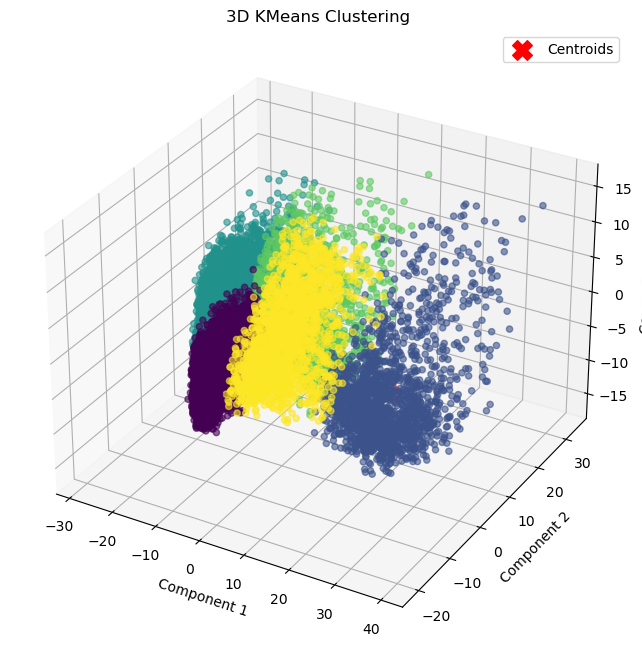

In [349]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points with their assigned clusters
scatter = ax.scatter(cleaned_data_3d[:, 0], cleaned_data_3d[:, 1], cleaned_data_3d[:, 2], c=k_labels, cmap='viridis', alpha=0.6, zorder = 1)

# Plot the cluster centers
ax.scatter(k_centers[:, 0], k_centers[:, 1], k_centers[:, 2], c='red', s=200, marker='X', label='Centroids', zorder = 10)

# Set labels and title
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('3D KMeans Clustering')
ax.legend()

plt.show()

In [ ]:
# TO BE DONE: Find a method that gives the lowest test error rate (and not training error rate) (p. 35) Lets get started on KNN
# 

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the data from NPY files
train_data = np.load('fashion_train.npy')
test_data = np.load('fashion_test.npy')

# Separate features (X) and labels (y) for both training and test sets
X_train = train_data[:, :-1]  # First 784 columns are the features (pixel values)
y_train = train_data[:, -1]   # Last column is the label (category)
X_test = test_data[:, :-1]    # Same for the test data
y_test = test_data[:, -1]

# Optional: If you want to merge the datasets and split randomly
X = np.vstack((X_train, X_test))
y = np.concatenate((y_train, y_test))

# Splitting into 80% training and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
num_folds = 5
group_kfold = GroupKFold(n_splits=num_folds)
group_kfold.get_n_splits(x_train_data, y_train_data, patient_id_train_data)


NameError: name 'x_train_data' is not defined

In [32]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler  # Import StandardScaler

# Load your data
data = np.load('fashion_train.npy')

# Separate X (pixel values) and y (labels)
X = data[:, :-1]  # First 784 columns (pixel values)
y = data[:, -1]   # 785th column (labels)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test_scaled = scaler.transform(X_test)  # Transform the test data using the same scaler

# Apply PCA to reduce the number of features (let's reduce to 100 components)
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)  # Fit PCA on standardized training data
X_test_pca = pca.transform(X_test_scaled)  # Transform the test data using the fitted PCA

# Now apply KNN on the PCA-transformed data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train)

# Make predictions
y_pred = knn.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # use 'macro' or 'micro' for multi-class
print(f"F1 Score: {f1:.4f}")

# Calculate ROC-AUC score
# For multi-class ROC-AUC, we need to use 'ovr' (one-vs-rest) strategy
y_prob = knn.predict_proba(X_test_pca)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate sensitivity (True Positive Rate) and specificity
# Sensitivity: TP / (TP + FN)
# Specificity: TN / (TN + FP)

# Assuming class 1 is the positive class for this example
TP = conf_matrix[1, 1]  # True Positives
TN = conf_matrix[0, 0]  # True Negatives
FP = conf_matrix[0, 1]  # False Positives
FN = conf_matrix[1, 0]  # False Negatives

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


Accuracy: 0.8210
F1 Score: 0.8195
ROC-AUC Score: 0.9482
Confusion Matrix:
[[352   0   5  13  45]
 [  4 363   3   6   3]
 [  5   0 321   7  55]
 [ 22   2   8 362  11]
 [ 97   1  57  14 244]]
Sensitivity: 0.9891
Specificity: 1.0000
